### Objectives:   
 1) Calculate the average hours per day that all Americans travel.    
 2) Observe the weekly cycles, if any, in reasons for travel.     
 3) Try to discern whether homes are closer to work or school, perhaps giving insight into housing market choices.    


<span style="color:green">
NB that notes in green are "magic carpet moments", where, in draft #1,   
I fly over the gaps/omissions/holes, for the sake of getting to the end of the first draft,   
in the blind faith that, in draft #2 +, I will fix them. text
</span>


### Data Source:   
Data from the Bureau of Labor Statistics' ATUS - the American Time-Use Survey.    
ATUS is itself is a sub-sampling of respondents previously surveyed in the Current Population Survey (CPS),   
a monthly survey to maintain knowledge of labor statistics.
https://www.kaggle.com/bls/american-time-use-survey

ATUS provides 9 linkable datasets. (more on that later)   
The full datasets, especially when merged need 4Gb of memory, so can cripple my laptop.  
Thus I choose to prototype my code with pruned down versions of each csv file.    
(That and other supporting code in separate python scripts) 

I will start with one which is itself a summary some of the others: "atussum.csv"   
It being *totals* of activity times, it is wider than the other cvs's (455 columns) but not so deep.   

<span style="color:green">NB that notes in green are "magic carpet moments", where, in draft #1,    
I fly over the gaps/omissions/holes, for the sake of getting to the end of the first draft,  
in the blind faith that, in draft #2+, I will fix them. </span>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
thinkful_data = '/Users/twaddy/NOTES/thinkful/DataSciBootCampPrep/cvs_data/atus/'
sum_fp        = os.path.join(thinkful_data, 'atussum.csv')
travel_sum_fp = os.path.join(thinkful_data, 'tw_atus_travel_sum.csv')

In [3]:
# The vast majority of columns and coded activities, for now, I shall discard:
# Keeping the first 24 columns that interest me and all columns related to travel.
# Also saving the data-reduced result for faster re-use later.

force_prune_sum_csv = False
if (not os.path.exists(travel_sum_fp)) or force_prune_sum_csv:
    df_sum = pd.read_csv(sum_fp)
    big_shape = df_sum.shape
    first_24 = list(df_sum.columns.values)[:24]
    travel_18s = list(df_sum.filter(regex='t18', axis=1))
    first24_and_travel = first_24 + travel_18s
    df_sum = df_sum.filter(items=first24_and_travel)
    lean_travel_shape = df_sum.shape
    
    print("#summary rows reduced from {0} to {1}".format(big_shape[0],df_sum.shape[0]))
    print("#summary cols reduced from {0} to {1}".format(big_shape[1],df_sum.shape[1]))
    print("writing out a csv file for summary data to help isolate, school run, commute and students...")
    df_sum.to_csv(path_or_buf=travel_sum_fp, mode = 'w', index=False)

    print("\nAlso in the summary data, we have {0} recorded reasons for travel.".format(len(travel_18s)))
else:
    df_sum = pd.read_csv(travel_sum_fp)

### Recall Objective 1:
1) Calculate the average hours per day that all Americans travel.       

Before diving into different, specific reasons for travel, let's sum all travel columns,  
whatever they represent and make a new column "all_travel" to hold that sum.

In [8]:
# Summing across columns ( hence: axis = 1) all those named in the list: travel_18s
travel_18s = list(df_sum.filter(regex='t18', axis=1))
df_sum['all_travel'] = df_sum[travel_18s].sum(axis=1)

# The average time spent traveling by Americans:
all_travelling_any_reason = df_sum['all_travel'].sum()
all_travellers = df_sum['all_travel'].count()
mean_travel_any_reason = round(all_travelling_any_reason / all_travellers)
in_hours = mean_travel_any_reason/60
print("\nAverage time Americans spend traveling = {0:.0f} mins".format(mean_travel_any_reason))
print("(ie {0:.2f} hours ... Travelling for any reason.)\n".format(in_hours))


Average time Americans spend traveling = 72 mins
(ie 1.20 hours ... Travelling for any reason.)



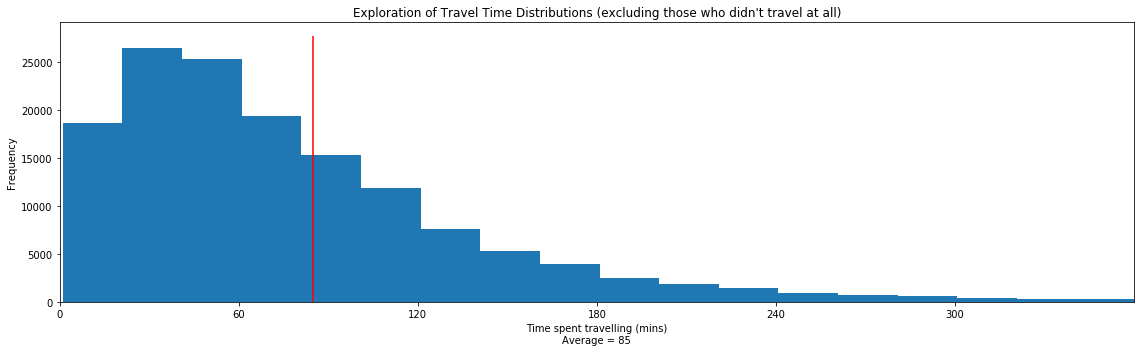

Presumably the right-skew from including those that "travel" for a living; taxi, truck, bus drivers etc
This is just the 'Summary data'. I need to press on... however, if I were to circle back...
I'd remove those professionals by merging data including 'occupation'.
(NB. There are 1902 trips lasting longer than 6 hours clipped away.)


In [23]:
# Let's plot that new "all_travel" column.
travel_mean = df_sum['all_travel'].mean()
some_travel_mean = df_sum['all_travel'].where(df_sum['all_travel'] > 0).mean()
exclude_stay_at_homes = df_sum['all_travel'].where(df_sum['all_travel'] > 0)
more_than_6_hours = df_sum['all_travel'].where(df_sum['all_travel'] > 360).count()

fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1, 1, 1)            # Create second matplotlib axes
exclude_stay_at_homes.plot(kind='hist', ax = ax1, bins=72)                   
plt.title("Exploration of Travel Time Distributions (excluding those who didn't travel at all)")
plt.xlabel('Time spent travelling (mins)\nAverage = {0:.0f}'.format(some_travel_mean))
plt.ylabel('Frequency')
plt.xlim([0, 360])
ymin, ymax = plt.ylim()
plt.xticks(range(0, 360, 60))
plt.vlines(some_travel_mean, 0, ymax, color='red')
plt.tight_layout()
plt.show()

print('Presumably the right-skew from including those that "travel" for a living; taxi, truck, bus drivers etc')
print("This is just the 'Summary data'. I need to press on... however, if I were to circle back...")
print("I'd remove those professionals by merging data including 'occupation'.")
print("(NB. There are {0} trips lasting longer than 6 hours clipped away.)".format(more_than_6_hours))

### How does travel, all_travel,  vary through the week?
Using groupby to examine how weekly patterns show in the data.

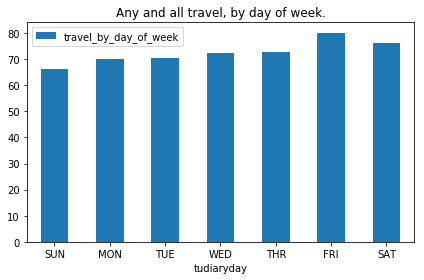

In [24]:
days_of_week = pd.Series(['SUN', 'MON', 'TUE', 'WED', 'THR', 'FRI', 'SAT'])
day_names = {0:'Sun', 1:'Mon',2:'Tues',3:'Weds',4:'Thurs',5:'Fri',6:'Sat'}
day_names_caps = ['SUN', 'MON', 'TUE', 'WED', 'THR', 'FRI', 'SAT']

# The output of a groupby is a series....
se_travel = df_sum.filter(items=['all_travel', 'tudiaryday']).groupby('tudiaryday')['all_travel'].mean()

#    WHY DID THESE MORE PYTHONESQUE WAYS FAIL? (merely trying to label bars with "Mon", "Tue" etc)
#df_travel['day_of_week'] = df_travel['tudiaryday'].apply(lambda x: day_names[x])
#df_travel['day_of_week'] = df_travel.apply(lambda x: day_names[x])
#df_travel['Col3'] = df_travel['index'].map(lambda x: day_names[x])

df_travel_reindexed = se_travel.reindex(['SUN', 'MON', 'TUE', 'WED', 'THR', 'FRI', 'SAT']).to_frame()
df_travel_reindexed['travel_by_day_of_week'] = list(se_travel)
df_travel_reindexed.plot(kind='bar', y='travel_by_day_of_week', title="Any and all travel, by day of week.", rot = 0)
plt.tight_layout()
plt.show()

I confess I'm surprised by how even this plot turns out to be.   
I assumed a strong weekly signal would be apparent, even in this data aggregated into "all_travel".     
More motivation of dive into details...

In [ ]:
# Here is a function to provide the description of specific reasons for travel.
# All activity codes, including travel related activities are in atuscodes.csv
codes_fp = '/Users/twaddy/NOTES/thinkful/DataSciBootCampPrep/cvs_data/atus/codes.csv'
df_codes = pd.read_csv(codes_fp)

def get_code_meaning(in_df=None, code=None):
    try:
        df_matches_with_nans = in_df.where(in_df['code'] == code)
        df_matches_no_nans = df_matches_with_nans.dropna(how='any')
        if len(df_matches_no_nans):
            meaning = df_matches_no_nans.iloc[0]['name']
            return meaning
        else:
            return None
    except IOError as e:
        print("get_code_meaning I/O error({0}): {1}".format(e.errno, e.strerror))

print("\nProvide meaning to {0} codes listed in travel_18s\n".format(len(travel_18s)))
for tcode in travel_18s:
    code = int(tcode[1:])
    meaning = get_code_meaning(in_df=df_codes, code=code)
    print("{0:9} -> {1}".format(tcode, meaning))

### Ok, so now we have an easy means to meaning, lets pick a few specific reasons for trips...

#### Choose two expected to have weekdays/weekend relevence:       
    1)t181302   -> Travel related to attending sporting/recreational events   
    2)t181401   -> Travel related to religious/spiritual practices   

####  choose another expected to have time-of-day patterns:   
    1)t181101   -> Travel related to eating and drinking   

####  Choose another expected to have non-earning partner, perhaps gender correlates
    1)t180381   -> Travel related to caring for and helping hh children  

Anticipating a similar "plot-per-week" for each of the above 4 travel codes,   
below is the function to do so, easily.

<span style="color:green"> DRAFT @2
In a loop of 4 activity codes, plot the per_week charts as sub plots
for easier inter comparison for the reader.  
Near working code/pseudo code in next box.
</span>

###  Objective 3)  Try to discern whether homes are closer to work or school  (perhaps giving insight into housing market choices.)

I'll attack this question twice:  
    1) First, just using the summary (which has codes for both work and education travel, but, for respondent only) 
    2) Second, merging with roster, respondents data, to confirm the household as kids.

In [ ]:
work_travel_codes = ['t180501', 't180502', 't180589']
edu_travel_codes = ['t180601', 't180699']

all_work_travel_df = df_sum[['t180501', 't180502', 't180589']]
all_edu_travel_df  = df_sum[['t180601', 't180699']]

all_work_travel_df = all_work_travel_df.rename(columns={"t180501": "working", 
                                                        't180502': "work_related", 
                                                        't180589': "work_n_e_c"})
all_edu_travel_df = all_edu_travel_df.rename(columns={"t180601": "taking_class", 
                                                      't180699': "edu_n_e_c"})

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1, 2, 1)      
all_work_travel_df.plot(kind='hist', ax=ax1, width=5, alpha = 0.5)
plt.title('Travel for work') 

ax2 = fig.add_subplot(1, 2, 2)     
all_edu_travel_df.plot(kind='hist' , ax=ax2, width=5, alpha = 0.5)
plt.title('Travel for education') 
plt.tight_layout()
plt.show()

# bars of different columns superimposed. Want side by side.

The above two plot seems more explorative than explanitive.  
Clarity needs simplicity. One "thing" for work Vs another "thing" for education, on common axes.  

<span style="color:green"> 
Draft #2
Aggregate/sum the above multiple codes/columns (still jut summary) and plot on common axes.
Maybe, since the summary retains info on if child under 18 in house, use that to find "the school run".
</span>

In [ ]:
# Merging data
#rost_fp = '/Users/twaddy/NOTES/thinkful/DataSciBootCampPrep/cvs_data/atus/atusrost.csv'
#rost_fp = '/Users/twaddy/NOTES/thinkful/DataSciBootCampPrep/cvs_data/atus/pruned_copies/pruned_atusrost.csv'
#df_rost = pd.read_csv(rost_fp)

#resp_fp = '/Users/twaddy/NOTES/thinkful/DataSciBootCampPrep/cvs_data/atus/atusresp.csv'
resp_fp = '/Users/twaddy/NOTES/thinkful/DataSciBootCampPrep/cvs_data/atus/pruned_copies/pruned_atusresp.csv'
df_resp = pd.read_csv(resp_fp)
df_resp.head()

In [ ]:
# To "explore/get a grip" on columns and what they mean, as I researched the documentation
# I accumulated a dictionary of the column descriptions, so, can use it here...
import atus_var_dictionary as avd
resp_cols = list(df_resp.columns.values)

missing_meanings = []
#for col in resp_cols:
for col in first_24:
    column_description, cvses = avd.get_col_meaning(col_head=col)
    if column_description:
        print("{0:14} ... means... {1}".format(col, column_description))
    else:
        missing_meanings.append(col)

In [ ]:
#act_rost_reports = pd.merge(activities_count, r_counts, on=['TESEX', 'TEAGE'], how='outer')
#act_rost_reports['reports_per_resp'] = act_rost_reports.reports / act_rost_reports.resp_count
#act_rost_reports.drop('resp_count', 1, inplace=True)
#act_rost_reports = act_rost_reports.groupby(['TUTIER1CODE', 'TUTIER2CODE', 'TUTIER3CODE', 'TESEX', 'TEAGE']).sum()
#act_rost_reports.head()